##**AIRCRAFT CLASSIFICATION**

In [11]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
from keras.utils import image_dataset_from_directory
import tensorflow as tf

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### **DATA PREPARATION**

In [7]:
# Read CSV files

train_data_path = '/content/drive/MyDrive/classification_aircraft/train.csv'
test_data_path = '/content/drive/MyDrive/classification_aircraft/test.csv'
val_data_path = '/content/drive/MyDrive/classification_aircraft/val.csv'

In [8]:
# Path to image directory

image_directory = '/content/drive/MyDrive/classification_aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/'

In [12]:
# Load CSV files

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)
df_val = pd.read_csv(val_data_path)

Below code concatenates the image directory path with the filenames in the training, testing, and validation sets. This step is essential for creating the full file paths required to locate the image files during data processing and model training.

In [13]:
# Concatenate the image directory path with the filenames in the training, testing, and validation sets

df_train['filename'] = image_directory + df_train['filename']
df_test['filename'] = image_directory + df_test['filename']
df_val['filename'] = image_directory + df_val['filename']

Function *preprocess_image* is defined to read, decode, augment, resize, and normalize images. Then, it creates a TensorFlow Dataset from a DataFrame containing filenames and corresponding labels, applies the preprocessing function to each sample in the dataset, shuffles and batches the dataset, and finally prefetches data for performance optimization.

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define a function to load and preprocess images
def preprocess_image(filename, label):
    # Read and decode the image file
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust channels as per your images

    # Apply random horizontal flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Resize the image
    image = tf.image.resize(image, [512, 512])  # Resize dimensions as per your requirement

    # Normalize the pixel values
    image = image / 255.0  # Rescale pixel values to [0, 1]

    return image, label

# Create a TensorFlow Dataset from the dataframe
dataset_train = tf.data.Dataset.from_tensor_slices((df_train['filename'], df_train['Labels']))

# Map the preprocess function to each sample in the dataset
dataset_train = dataset_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the dataset
batch_size = 32
dataset_train = dataset_train.shuffle(buffer_size=len(df_train)).batch(batch_size)

# Optionally, you can prefetch data to optimize performance
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Check if the dataset is correctly created
print(dataset_train)



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [15]:

# Create a function to load and preprocess images for test and validation sets
def preprocess_image_test_val(filename, label):
    # Read and decode the image file
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust channels as per your images

    # Resize the image
    image = tf.image.resize(image, [512, 512])  # Resize dimensions as per your requirement

    # Normalize the pixel values
    image = image / 255.0  # Rescale pixel values to [0, 1]

    return image, label

# Create datasets for test and validation sets
dataset_test = tf.data.Dataset.from_tensor_slices((df_test['filename'], df_test['Labels']))
dataset_val = tf.data.Dataset.from_tensor_slices((df_val['filename'], df_val['Labels']))

# Map the preprocess function to each sample in the test and validation datasets
dataset_test = dataset_test.map(preprocess_image_test_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.map(preprocess_image_test_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the test and validation datasets
batch_size = 32
dataset_test = dataset_test.batch(batch_size)
dataset_val = dataset_val.batch(batch_size)


dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



### **MODEL TRAINING**

This model architecture utilizes transfer learning with the InceptionV3 pre-trained convolutional base. The base model is frozen, and a global average pooling layer is added to reduce spatial dimensions. Subsequently, three dense layers with batch normalization, activation, and dropout are stacked for feature extraction and classification. The final dense layer with softmax activation outputs probabilities across 100 classes.

In [11]:
from tensorflow.keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = tf.keras.applications.inception_v3.InceptionV3(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(512,512,3)
                     )

base_model.trainable=True

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),  # Add activation after batch normalization
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation='softmax')
    ])



87910968/87910968 [==============================] - 0s 0us/step


In [10]:
optim = Adam(learning_rate=0.0001)
# The model optimises cross entropy as its loss function and will monitor classification accuracy:
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_94 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 activation_94 (Activation)  (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(dataset_train, epochs=50, validation_data=dataset_val, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/50
105/105 [==============================] - 414s 1s/step - loss: 5.5952 - accuracy: 0.0114 - val_loss: 4.6163 - val_accuracy: 0.0126
Epoch 2/50
105/105 [==============================] - 38s 258ms/step - loss: 5.1803 - accuracy: 0.0234 - val_loss: 4.3276 - val_accuracy: 0.0654
Epoch 3/50
105/105 [==============================] - 38s 258ms/step - loss: 4.5970 - accuracy: 0.0543 - val_loss: 3.9120 - val_accuracy: 0.1206
Epoch 4/50
105/105 [==============================] - 38s 257ms/step - loss: 4.1465 - accuracy: 0.0963 - val_loss: 3.5687 - val_accuracy: 0.1749
Epoch 5/50
105/105 [==============================] - 38s 258ms/step - loss: 3.7293 - accuracy: 0.1608 - val_loss: 3.2900 - val_accuracy: 0.2718
Epoch 6/50
105/105 [==============================] - 38s 259ms/step - loss: 3.3235 - accuracy: 0.2172 - val_loss: 2.9078 - val_accuracy: 0.3324
Epoch 7/50
105/105 [==============================] - 38s 258ms/step - loss: 2.9946 - accuracy: 0.2780 - val_loss: 2.4915 - val_accu

In [20]:

# Define the directory path where you want to save the model
save_dir = '/content/drive/MyDrive/classification_aircraft/'

# Save model
model.save(save_dir + 'trained_model_imagenet.h5')

# Save only the weights
model.save_weights(save_dir + 'model_weights_imagenet.h5')


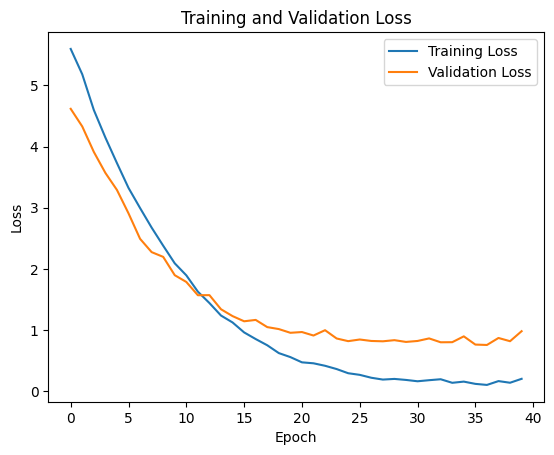

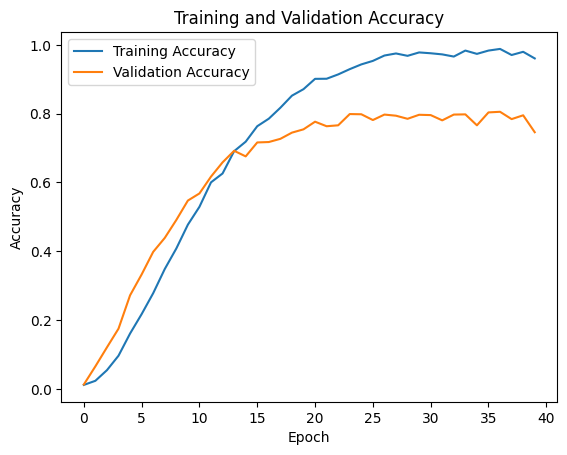

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Loss has gradually descended and accuracy gradually increased indicating that model is learnig well.

In [14]:
_, acc = model.evaluate(dataset_test, verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

105/105 [==============================] - 125s 1s/step - loss: 0.7483 - accuracy: 0.8056
Accuracy: 80.558


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Predict on test set
y_pred = model.predict(dataset_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in dataset_test], axis=0)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')

# Create Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print metrics
print(f'Accuracy: {accuracy*100:.3f}%')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print('Confusion Matrix:')
print(conf_matrix)


105/105 [==============================] - 8s 73ms/step
Accuracy: 80.558%
Precision: 0.822
Recall: 0.806
Confusion Matrix:
[[31  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 1  0  0 ... 30  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  1  0 30]]


**Conclusion**

 The model using the Adam optimizer with a learning rate of 0.0001, cross-entropy loss function, and accuracy metric for monitoring. It also defines early stopping with patience set to 3 epochs. The model is then trained using the provided training and validation datasets for up to 50 epochs with a batch size of 32, utilizing the early stopping callback for efficient training.

 Overall, the model appears to perform reasonably well, with high accuracy, precision, and recall scores.

Model has performed well and accuracy on test set is above 80%


In [4]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.7 MB/s eta 0:00:00


**HYPERPARAMETER TUNING**

 I have implemented hyperparameter tuning using Keras Tuner's RandomSearch to optimize the architecture and training parameters of a deep learning model based on InceptionV3. It searches for the best combination of hyperparameters, including the number of units in dense layers, dropout rates, and optimizer choices, to maximize validation accuracy. The process aims to enhance the model's performance by systematically exploring a predefined search space and selecting the optimal configuration.

Using this technique I wanted to investigate if any other combination of parameters with adam or rmpsprop optimiser gived better result than previous model.

In [22]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define a function to build the model
def build_model(hp):
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(512, 512, 3)
    )
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.2)),
        Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.2)),
        Dense(100, activation='softmax')
    ])

     # Define the optimizer as a hyperparameter
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])  # Add optimizer choice

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=0.0001)  # Learning rate set to 0.0001 for the scheduler
    else:
        optimizer = RMSprop(learning_rate=0.0001)  # Learning rate set to 0.0001 for the scheduler

    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the RandomSearch tuner to search for the best hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Total number of trials (model configurations) to test
    directory='/content/drive/MyDrive/classification_aircraft/',  # Directory to save the search results
    project_name='hyperparameter_tuning_aircraft_task'  # Name for the project
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(dataset_train,
             epochs=50,
             validation_data=dataset_val,
             batch_size=[32, 64],  # Batch size to be tuned
             callbacks=[early_stopping])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hp}")


Trial 5 Complete [00h 03m 10s]
val_accuracy: 0.012301229871809483

Best val_accuracy So Far: 0.7845784425735474
Total elapsed time: 01h 18m 59s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x79e311be9570>


In [23]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the values of the hyperparameters
best_units = best_hp.get('units')
best_dropout = best_hp.get('dropout')
best_optimizer = best_hp.get('optimizer')

# Print the best hyperparameters
print("Best units:", best_units)
print("Best dropout:", best_dropout)
print("Best optimizer:", best_optimizer)


Best units: 1024
Best dropout: 0.5
Best optimizer: adam


In [26]:
# Save the best model
save_dir = '/content/drive/MyDrive/classification_aircraft/'
best_model.save(save_dir + 'best_model_hyperparametertuning.h5')


In [28]:

import warnings
warnings.filterwarnings("ignore", message="Value in checkpoint could not be found in the restored object")

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(dataset_test)

# Predict the labels for the test dataset
y_pred_prob = best_model.predict(dataset_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.concatenate([y for _, y in dataset_test], axis=0)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate accuracy, precision, and recall
accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100

# Print the evaluation metrics in percentage format
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy * 100, "%")
print("Precision:", precision_percentage, "%")
print("Recall:", recall_percentage, "%")
print("Confusion Matrix:\n", conf_matrix)



105/105 [==============================] - 9s 71ms/step
Test Loss: 0.8216181993484497
Test Accuracy: 77.64776349067688 %
Precision: 79.74286383360038 %
Recall: 77.64776477647764 %
Confusion Matrix:
 [[30  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  3  0]
 [ 0  0  0 ...  0 32  0]
 [ 0  0  0 ...  0  0 32]]


Hyper parameter tuning  has suggested best model is formed with

* Best units: 1024

* Best dropout: 0.5

* Best optimizer: adam

Test Accuracy is 77.647%



### **PREDICTION**

Saving 2265511.jpg to 2265511.jpg
1/1 [==============================] - 5s 5s/step


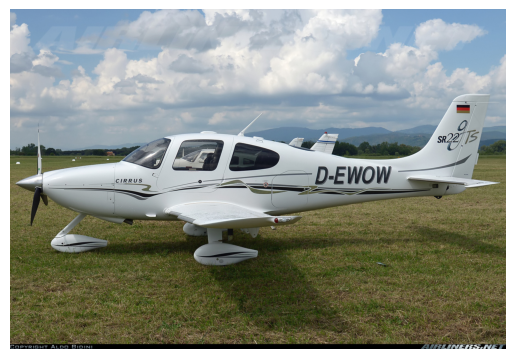

Predicted class: 92


In [2]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Define the directory path where the model is saved
save_dir = '/content/drive/MyDrive/classification_aircraft/'

# Load the saved model
model = tf.keras.models.load_model(save_dir + 'trained_model_imagenet.h5')

# Define a function to preprocess images
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(512, 512))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Upload image from Colab
uploaded = files.upload()

# Get the image file name
image_path = list(uploaded.keys())[0]

# Preprocess the uploaded image
preprocessed_image = preprocess_image(image_path)

# Predict the class of the uploaded image
predictions = model.predict(preprocessed_image)
predicted_class = tf.argmax(predictions, axis=1)[0].numpy()

# Display the uploaded image
img = tf.keras.preprocessing.image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the predicted class
print("Predicted class:", predicted_class)


Above image is correctly classified which determines models success.

The achieved maximum accuracy in our experiments is 80.5%, with a potential variability of approximately ±3-4% due to data sampling during batch training. This inherent variability impacts hyperparameter tuning, potentially resulting in slightly lower accuracies compared to the initial model. Understanding this context is essential for interpreting model performance accurately. Despite fluctuations, continued evaluation and exploration of different hyperparameter configurations remain crucial for finding the best-performing model.

Overall, the combination of its pre-trained weights, effective architectural design, and computational efficiency makes InceptionV3 a preferred choice for transfer learning tasks, enabling practitioners to achieve impressive results with less data and computational resources compared to training models from scratch or using other architectures.
This is the reason I chose to use inceptionv3 pretrained model. Also paper - Rethinking the Inception Architecture for Computer Vision - by Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe and Jonathon Shlens experimented error in inception v3 is comparitively less than GoogleNet, VGG,BN-Inception models.

Best model characteristics - Incorporates dense (fully connected) layers with ReLU activation to capture high-level features from the global average pooled features. The dense layers help in learning non-linear relationships between features.

Adam optimizer with a learning rate of 0.0001, which is a popular choice for training deep neural networks due to its adaptive learning rate.

Batch normalisation helping in faster convergence and reducing the sensitivity to the initialization of network parameters






**To reproduce the provided code, follow these steps:**

1. Prepare Dataset: Organize your dataset according to the requirements of your task. Ensure that you have separate directories for training, validation, and testing sets if applicable.

2. Run Data Preparation Steps: Execute the code provided for data preparation. This includes loading the pre-trained model, adding custom layers, compiling the model, and setting up data generators for training and validation.

3. Load First Saved Model: Load the first model saved using the provided code snippet. Replace '/Folder/trained_model_imagenet.h5' with the actual path where your trained model is saved.
>>model = tf.keras.models.load_model('/Folder/trained_model_imagenet.h5')

4. Use Model as Required: Utilize the loaded model for your specific tasks. You can perform tasks such as making predictions on new data, evaluating its performance, or fine-tuning it further if necessary.

5. Prediction Code: Refer to the prediction code provided in the last part of the task. This code allows you to upload an image for testing and displays the predicted class label along with the image.

6. To run the prediction code:

  Execute the code chunk provided for testing the image.
  This code will prompt you to upload an image. Click on the "upload" button and select the image you want to test.
  The model will predict the class of the uploaded image and display the predicted class label at the bottom of the image.
  Follow these steps sequentially to reproduce the code and perform runtime predictions using the loaded model. Adjust paths, filenames, and any other parameters as necessary based on your specific setup and requirements.






